In [10]:
from xhermes.load import open_hermesdataset
from xhermes.utils import guard_replace_1d
import xbout
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction
This notebook shows the basics of 1D postprocessing using the 1D-recycling example case. Please refer to the xHermes readme for installation instructions. 2D and 3D postprocessing may vary. Reading Xarray documentation is recommended.

**IMPORTANT NOTE:** If you are getting errors that some variables are not found, please ensure you put "diagnose = true" below every species block in the input file before you run the simulation.

# Read datafile
- Dump files contain the results.
- Restart files contain info needed to restart Hermes-3 from old results (not used for postprocessing)
- Log files show console dump of a run.
- BOUT.inp stores the user settings.
- BOUT.settings both user and default settings upon **successful run completion**. It will not update if the run was interrupted or crashed. 

To read a simulation, you must pass a datapath. Inputfilepath is optional, and you can use either BOUT.inp or BOUT.settings there. The parser contents will be in ds.options.

1D notes:
- In 1D, it is recommended to read the file with yboundaries (guard/ghost cells) so that we can reconstruct boundary values at the upstream and target.
- ds.extract_1D_tokamak_geometry calculates geometric quantities such as cross-sectional areas and volumes.

**IMPORTANT NOTE:** If you read a simulation into a Jupyter notebook and then ran it again and generated new data, it will not update upon rerunning the below cell. This is a longstanding bug related to Xarray caching. If you must reread a file, restart the kernel. 

In [11]:
ds = open_hermesdataset(
    datapath = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\examples\1D-recycling-master-2024-09-12-nosoundspeed\BOUT.dmp.*.nc",
    inputfilepath = r"C:\Users\mikek\OneDrive\Project\collab\tech\cases\examples\1D-recycling-master-2024-09-12-nosoundspeed\BOUT.settings",
    keep_yboundaries = True
    )

ds = ds.hermes.extract_1d_tokamak_geometry()

c:\Users\mikek\OneDrive\Project\pyenvs\fusion-a-310\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


# Datasets and DataArrays
- xHermes uses Xarray. "ds" is an Xarray Dataset. Variables such as ds["Te"] are DataArrays. Please refer to Xarray documentation.

# Coordinates
- xHermes is a wrapper around xBOUT, which itself is a wrapper around Xarray. 
- Xarray allows your arrays to have metadata and consistent coordinates.
- It has very good documentation: https://docs.xarray.dev/en/stable/getting-started-guide/index.html
- We often use built-in Xarray plotting tools, here is the relevant docs page: https://docs.xarray.dev/en/stable/user-guide/plotting.html
- Xarray has a particular way of selecting/indexing the arrays by using the dimensions, **please make sure you read this**: https://docs.xarray.dev/en/stable/user-guide/indexing.html

Coordinates can be extracted as follows:

In [12]:
ds.coords

Coordinates:
    dx       (pos) float64 dask.array<chunksize=(52,), meta=np.ndarray>
    dy       (pos) float64 dask.array<chunksize=(52,), meta=np.ndarray>
    dz       (pos) float64 dask.array<chunksize=(52,), meta=np.ndarray>
  * t        (t) float64 0.0 5.22e-05 0.0001044 ... 0.005115 0.005168 0.00522
    x        int32 0
    y        (pos) float64 0.0715 0.2143 0.3568 0.499 ... 30.27 30.28 30.29 30.3
    z        float64 3.142
  * pos      (pos) float64 -0.2141 -0.07125 0.07125 0.2134 ... 30.0 30.0 30.01

- dx, dy and dz are cell widths, with x being radial, y poloidal and z the toroidal. In 1D simulations, the domain is still "3D", but is one cell wide in the y and z directions.
- t is time in [s]
- pos is the parallel position in [m]

Basic Xarray indexing examples:

In [13]:
#  ds.isel(t=-1)                          # Last timestep (index selection)
#  ds.sel(t = slice(0.01, None))          # Select times from 0.01 seconds to final timestep (value selection)
#  ds.sel(t = -1, pos = -1)               # Final timestep and final cell
#  ds.sel(pos = 5, method = "nearest")    # Select cell nearest to position of 5m

# Basic plots

## Domain without guard cells
- Hermes-3 has 2 guard (ghost) cells on each side of the domain. The outer ones are used only for higher order boundary conditions in BOUT++ and are not used in Hermes-3. You can obtain the boundary value by interpolating between the final cell centres and the inner guard cell centres:


```Cell order at target:
    ... | last | guard | second guard (unused)
                ^target      
        |  -3  |  -2   |      -1
```


Text(0, 0.5, 'Temperature [eV]')

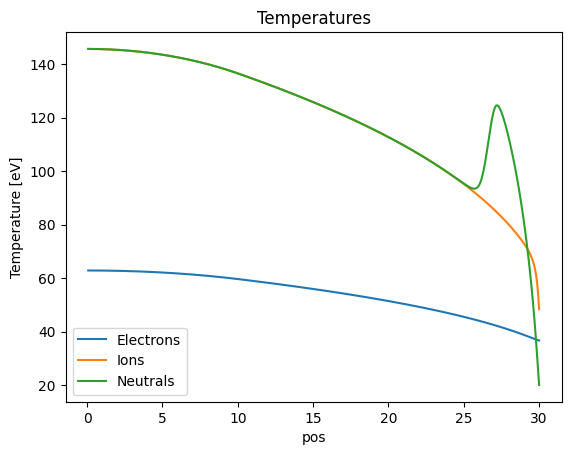

In [14]:
ds2 = ds.isel(pos = slice(2,-2), t = -1)  # Select domain without guard cells and final timestep

fig, ax = plt.subplots()
ds2["Te"].plot(ax = ax, label = "Electrons")
ds2["Td+"].plot(ax = ax, label = "Ions")
ds2["Td"].plot(ax = ax, label = "Neutrals")
ax.legend()
ax.set_title("Temperatures")
ax.set_ylabel("Temperature [eV]")

## Plots with fields at boundaries
To calculate the boundary values, we perform guard replacement, where the outer guard cells are removed (as they are unused) and the inner guard cell values are replaced with the boundary values. This allows you to simply query the first or last value to get the upstream and target values.

The guard_replace_1d function can accept an Xarray DataArray or a regular Numpy array. You cannot pass coordinate DataArrays as these are immutable, which is why the below example converts it to a Numpy array using.values().

Target values:
Te:  36.68441619422116
Td+:  47.979926151423236
Td:  47.979926151423236


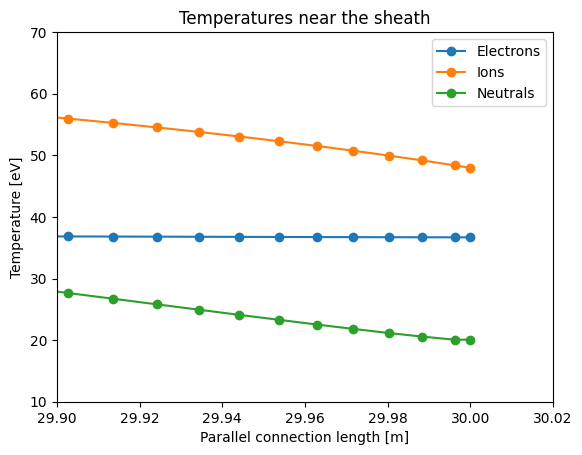

In [15]:
ds2 = ds.isel(t=-1)   # select final timestep, keep boundaries

spar = guard_replace_1d(ds2["pos"].values)

fig, ax = plt.subplots()
ax.plot(spar, guard_replace_1d(ds2["Te"]), label = "Electrons", marker = "o")
ax.plot(spar, guard_replace_1d(ds2["Td+"]), label = "Ions", marker = "o")
ax.plot(spar, guard_replace_1d(ds2["Td"]), label = "Neutrals", marker = "o")

ax.legend()
ax.set_title("Temperatures near the sheath")
ax.set_xlabel("Parallel connection length [m]")
ax.set_ylabel("Temperature [eV]")
ax.set_xlim(29.9, 30.02)
ax.set_ylim(10,70)

print("Target values:")
print("Te: ", guard_replace_1d(ds2["Te"]).isel(pos = -1).values)
print("Td+: ", guard_replace_1d(ds2["Td+"]).isel(pos = -1).values)
print("Td: ", guard_replace_1d(ds2["Td+"]).isel(pos = -1).values)

# Time history plots

## 2D plot of 1D field time history
- This is done using built-in Xarray methods, please refer to Xarray docs for details.

Text(0.5, 1.0, 'Time history of domain electron temperature')

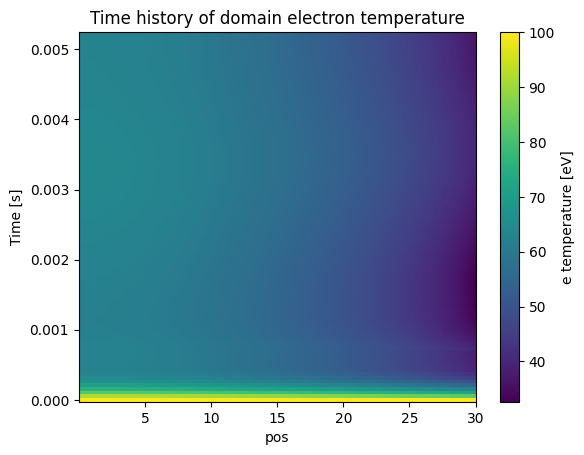

In [16]:
ds2 = ds.isel(pos = slice(2,-2))  # Select domain without guard cells, but all timesteps

fig, ax = plt.subplots()

ds2["Te"].plot(ax = ax)
ax.set_title("Time history of domain electron temperature")

## 1D plot of the time history of a point
- Simply select a single point with .isel() or .sel() and plot. Again, this is standard Xarray plotting.
- With guard replacement, the target value is at index -1.
- If you don't guard replace, make sure to take out the guards with .isel(pos = slice(2,-2)) and then you can access the last cell centre at -1.

Text(0.5, 1.0, 'Target temperature history')

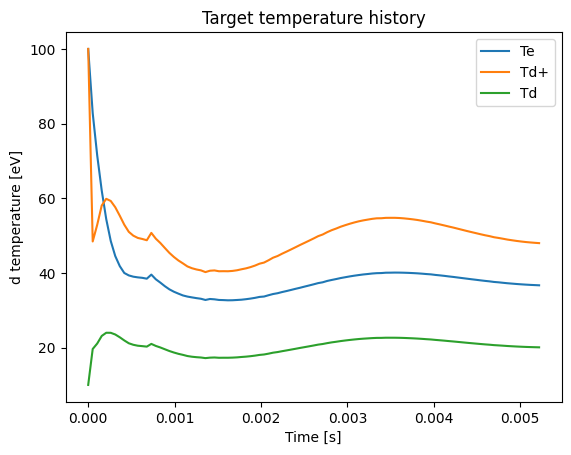

In [17]:
fig, ax = plt.subplots()

guard_replace_1d(ds["Te"]).isel(pos=-1).plot(ax = ax, label = "Te")
guard_replace_1d(ds["Td+"]).isel(pos=-1).plot(ax = ax, label = "Td+")
guard_replace_1d(ds["Td"]).isel(pos=-1).plot(ax = ax, label = "Td")
ax.legend()

ax.set_title("Target temperature history")

# Integral quantities
- It is useful to do integrals over the domain, e.g. to get total radiation.
- Hermes-3 is a finite volume code, so each source quantity is constant within a cell.
- This means you simply sum the source multiplied by volume. DO NOT do numerical integration.


**IMPORTANT NOTE 1:** guard cell values of sources are not defined and can often have garbage values. This is on the to do list to make less confusing. When working with sources, take off the guard cells.

**IMPORTANT NOTE 2:** Energy integrals may seem large in 1D, but this is because the domain is 2pi long in the toroidal by default.

**IMPORTANT NOTE 3:** The sign convention is positive for sources. This means radiation is negative as it's a domain energy sink.

Final excitation radiation domain integral: -17.00 MW



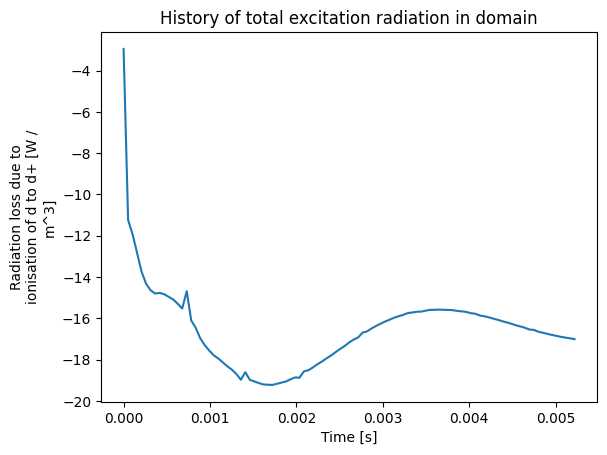

In [18]:
ds2 = ds.isel(pos = slice(2,-2))

total_radiation = (ds["Rd+_ex"] * ds["dv"]).sum("pos") * 1e-6   # Sum of MW/m3 times m3 over domain


print(f"Final excitation radiation domain integral: {total_radiation.isel(t=-1):.2f} MW")

total_radiation.plot()
plt.title("History of total excitation radiation in domain")
print()   # Blank print, otherwise notebooks print the last line by default..

# Metadata inside the dataset
The beauty of Xarray is that there's lots of metadata around. It's worthwhile to take a look through it.

## Variable metadata

In [19]:
for name in ds:
    param = ds[name]
    
    if "units" in param.attrs:
        print(f'{name} [{param.attrs["units"]}]: {param.attrs["long_name"]}')
    else:
        print(f'{name}: Attributes not yet implemented')


Bxy: Attributes not yet implemented
Ed+_iz [W / m^3]: Energy transfer due to ionisation of d to d+
Ed+_rec [W / m^3]: Energy transfer due to recombination of d+ to d
Ed_target_recycle [W m^-3]: Target recycling energy source of d
Edd+_cx [W / m^3]: Energy transfer to d from d+ due to CX with d+
Fd+_iz [kg m^-2 s^-2]: Momentum transfer due to ionisation of d to d+
Fd+_rec [kg m^-2 s^-2]: Momentum transfer due to recombination of d+ to d
Fdd+_cx [kg m^-2 s^-2]: Momentum transfer to d from d+ due to CX with d+
G1: Attributes not yet implemented
G2: Attributes not yet implemented
G3: Attributes not yet implemented
J [m/radian T]: Jacobian to translate from flux to cylindrical coordinates in real space
Kdd+_cx [s^-1]: CX collision frequency betweend and d+ producingd+ andd. Note Kab != Kba
NVd [kg / m^2 / s]: d parallel momentum
NVd+ [kg / m^2 / s]: d+ parallel momentum
Nd [m^-3]: d number density
Nd+ [m^-3]: d+ number density
Ne [m^-3]: e number density
Pd [Pa]: d pressure
Pd+ [Pa]: d+ pre

## Assorted metadata, including species

In [20]:
ds.metadata

{'BOUT_VERSION': 5.2,
 'Bnorm': 1.0,
 'Cs0': 97871.51425755137,
 'HERMES_REVISION': 'e509b1b6efd6dd97731c75285294d7ee38eec77e',
 'HERMES_SLOPE_LIMITER': 'MC',
 'MXG': 0,
 'MXSUB': 1,
 'MYG': 2,
 'MYPE': 0,
 'MYSUB': 50,
 'MZ': 1,
 'MZG': 0,
 'MZSUB': 1,
 'NXPE': 1,
 'NYPE': 8,
 'NZPE': 1,
 'Nnorm': 1e+19,
 'Omega_ci': 95788333.03066081,
 'PE_XIND': 0,
 'PE_YIND': 0,
 'Tnorm': 100.0,
 'ZMAX': 1.0,
 'ZMIN': 0.0,
 'has_adios2': 0,
 'has_caliper': 0,
 'has_cuda': 0,
 'has_fftw': 1,
 'has_gettext': 1,
 'has_hypre': 0,
 'has_lapack': 0,
 'has_netcdf': 1,
 'has_petsc': 1,
 'has_pretty_function': 1,
 'has_pvode': 1,
 'has_raja': 0,
 'has_scorep': 0,
 'has_slepc': 0,
 'has_sundials': 1,
 'has_umpire': 0,
 'hist_hi': 99,
 'iteration': 99,
 'ixseps1': -1,
 'ixseps2': -1,
 'jyseps1_1': -1,
 'jyseps1_2': 200,
 'jyseps2_1': 200,
 'jyseps2_2': 399,
 'nx': 1,
 'ny': 400,
 'ny_inner': 200,
 'nz': 1,
 'openmp_threads': 1,
 'rho_s0': 0.0010217477552952484,
 'run_id': '635e3426-8708-4b53-a73e-5ac64eb0d03e

## Options used to run simulation

In [21]:
print(ds.options.as_tree())

root
 |- IncIntShear = false
 |- MXG = 0
 |- MYG = 2
 |- ZMAX = 1
 |- ZMIN = 0
 |- append = false
 |- async_send = false
 |- datadir = 1D-recycling-master-2024-09-12-nosoundspeed
 |- dump_on_restart = true
 |- non_uniform = true
 |- nout = 100
 |- optionfile = BOUT.inp
 |- periodicX = false
 |- restart = false
 |- settingsfile = BOUT.settings
 |- stopCheck = false
 |- stopCheckName = BOUT.stop
 |- timestep = 5000
 |- twistshift = false
 |- wall_limit = -1
 |- NVd
 |   |- evolve_bndry = false
 |- NVd+
 |   |- evolve_bndry = false
 |   |- function = 0
 |- Nd
 |   |- evolve_bndry = false
 |   |- function = 0.001
 |   |- neumann_boundary_average_z = false
 |   |- source = <Field3D>
 |   |- source_only_in_core = false
 |   |- source_time_dependent = false
 |- Nd+
 |   |- evolve_bndry = false
 |   |- function = 1
 |   |- neumann_boundary_average_z = false
 |   |- source = <Field3D>
 |   |- source_only_in_core = false
 |   |- source_shape = H(mesh:y_xpt - y) * 1e20
 |   |- source_time_depende